In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy
import scipy.stats
import h5py
import pandas as pd
import cv2

from utils import behavioral_segmentation

plt.rcParams['figure.figsize'] = (9, 9)

In [42]:
# Papermill parameters 
# This cell has the parameters tag (View -> Cell Toolbar -> Tags)
# These variables can be overriden via command-line at runtime

lfp_file = '/LFP-Behavior/data/processed/aligned_hippo_lfp_50hz.npy' # time-aligned LFP data
lfp_fs = 50 # sampling frequency of time-aligned LFP data

xMM_file = '/LFP-Behavior/data/processed/aligned_xMM_sub10hz.npy' # time-aligned xMM data
xMM_fs = 10 # sampling frequency of time-aligned xMM data

yMM_file = '/LFP-Behavior/data/processed/aligned_yMM_sub10hz.npy' # time-aligned yMM data
yMM_fs = 10 # sampling frequency of time-aligned yMM data

sect_file = '/LFP-Behavior/data/processed/aligned_sect_sub10hz.npy' # time-aligned yMM data
sect_fs = 10 # sampling frequency of time-aligned yMM data

[(662, 698, 9), (1940, 2160, 9), (2604, 2664, 9), (3378, 3572, 9), (4382, 4603, 9), (5131, 5324, 9), (6030, 6245, 9), (6593, 6617, 9), (7583, 7791, 9), (8598, 8809, 9), (9371, 9563, 9), (10369, 10573, 9), (11386, 11597, 9), (12445, 12649, 9), (13195, 13441, 9), (14106, 14312, 9), (14827, 15021, 9), (15745, 15938, 9), (16526, 16710, 9), (17606, 17789, 9), (17875, 17917, 9), (18830, 19023, 9), (19705, 19893, 9), (20678, 20871, 9), (21698, 21878, 9), (22414, 22601, 9), (23467, 23643, 9), (23653, 23665, 9), (24282, 24470, 9), (25259, 25457, 9), (27014, 27052, 9), (28531, 28713, 9), (30095, 30300, 9), (30851, 30881, 9), (31828, 32010, 9), (32023, 32034, 9), (32066, 32096, 9), (32693, 32729, 9), (33452, 33643, 9), (34208, 34380, 9), (35103, 35283, 9), (35937, 36119, 9), (36810, 36981, 9), (37506, 37718, 9), (38348, 38528, 9), (39393, 39597, 9), (40065, 40087, 9), (40889, 41095, 9), (41779, 41963, 9), (42787, 42973, 9), (43769, 43952, 9), (44702, 44879, 9), (45727, 45895, 9), (47716, 47906, 9

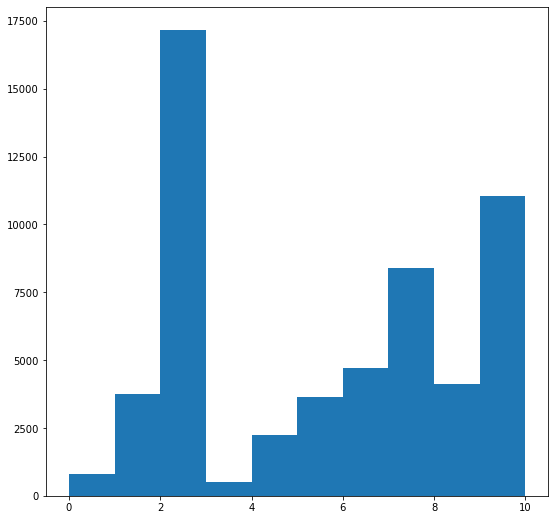

In [43]:
sect_10hz = np.load(sect_file)
plt.hist(sect_10hz, bins=np.arange(11))
segments = behavioral_segmentation.extract_segments(sect_10hz, [7, 8, 9])
segments = [seg for seg in segments if seg[2] == 9.0]
print(segments)
trimmed_segments = np.load('data/datasets/stationary_rat/trimmed_segments.npy')

In [44]:
np.argmax([trimmed_segments[i][1] - trimmed_segments[i][0] for i in range(len(trimmed_segments))])

58

In [45]:
segments[59]

(53673, 53936, 9)

In [39]:
trimmed_segments[58]

array([53679, 53932,     9])

In [40]:
vid_index =  51
vid_folder = '{}_{}_{}'.format(*segments[vid_index+1])
vid_path = 'data/datasets/stationary_rat/videos/{}/{}/'.format(vid_folder, vid_folder)

s, e, sect = trimmed_segments[vid_index]
s, e, sect = segments[vid_index]
print(vid_path)
frames = []
for i in range(s, e):
    img = cv2.imread(vid_path + str(i) + '.jpg')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.normalize(gray, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    #ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    plt.imshow(gray, cmap='gray')
    frames.append(gray.flatten())

frames = np.array(frames)
mean = np.mean(frames, axis=0)
frames = frames - mean

data/datasets/stationary_rat/videos/45727_45895_9/45727_45895_9/


error: OpenCV(3.4.11) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-hzi5bf28\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


# PCA

In [8]:
frames.shape

(156, 22000)

In [9]:
U, S, V_h = np.linalg.svd(np.array(frames), full_matrices=False)
    
# PC = XV = US
pc = np.matmul(U, np.diag(S))

In [10]:
U.shape

(156, 156)

In [11]:
S.shape

(156,)

In [12]:
pc.shape

(156, 156)

In [13]:
modes = pc[:50,:]

In [14]:
pc1 = np.matmul(frames.T, modes[0])

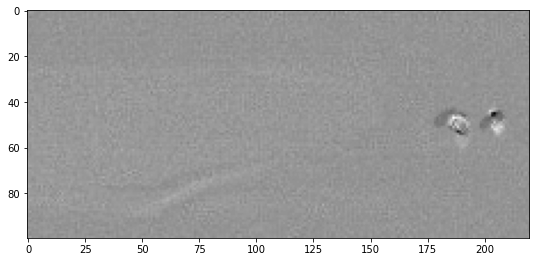

In [15]:
plt.imshow(pc1.reshape(100,-1) + mean.reshape(100,-1), cmap='gray')
plt.show()

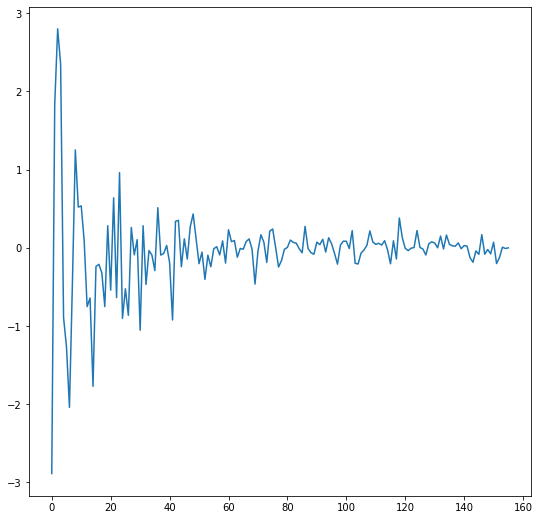

In [16]:
plt.plot(modes[2])

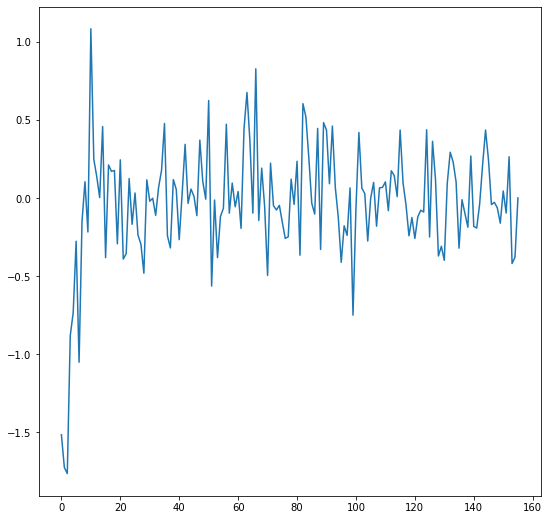

In [17]:
plt.plot(modes[-1])

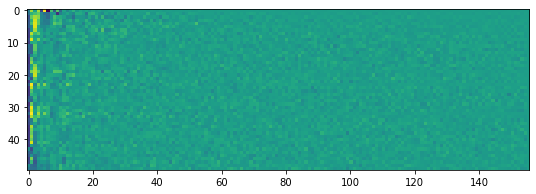

In [18]:
plt.imshow(modes)

# Wavelet Decomposition

In [19]:
from scipy import signal

In [20]:
def cwt_transform(mode, verbose = False):
    w = 4
    t, dt = np.linspace(0, (len(mode)-1)/10, len(mode), retstep=True)
    freq = np.linspace(1, 5, 5)
    widths = w*10 / (2*freq*np.pi)

    cwtm = signal.cwt(mode, signal.morlet2, widths, w=w)
    
    if(verbose):
        plt.pcolormesh(t, freq , np.abs(cwtm), cmap='viridis', shading='gouraud')
        plt.colorbar()
        plt.show()
    
    return np.abs(cwtm)

In [21]:
X = []
for mode in modes:
    spectrogram = cwt_transform(mode, verbose=0)
    spectrogram = spectrogram/np.max(spectrogram)
    X.append(spectrogram)
X = np.concatenate(np.array(X)).T

In [22]:
# Training Data (time, spectrogram feature vector)
X.shape

(156, 250)

# T-SNE

In [23]:
from sklearn.manifold import TSNE

In [24]:
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

(156, 2)

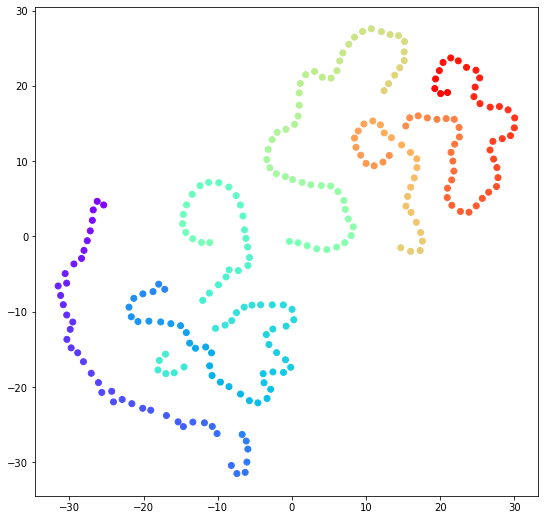

In [365]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], color = cm.rainbow(np.linspace(0, 1, 253)))

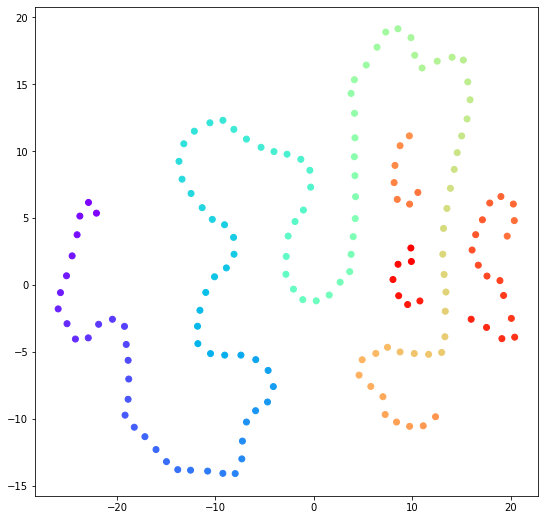

In [26]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], color = cm.rainbow(np.linspace(0, 1, len(X_embedded))))

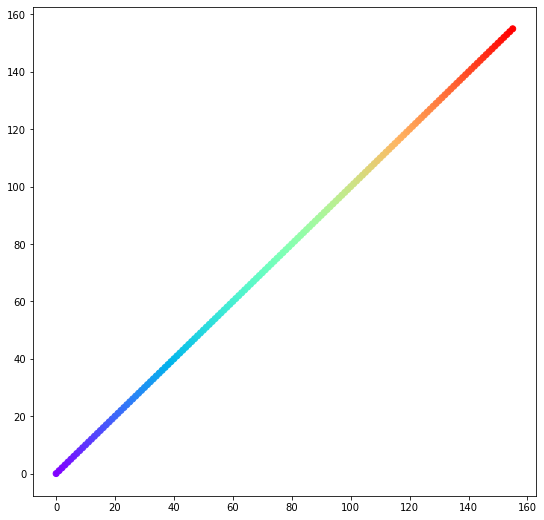

In [28]:
plt.scatter(np.arange(len(X_embedded)), np.arange(len(X_embedded)), color = cm.rainbow(np.linspace(0, 1, len(X_embedded))))